Found 1506 images belonging to 3 classes.
Found 373 images belonging to 3 classes.
Found 373 images belonging to 3 classes.

FC Only
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5621 - loss: 0.8816
Epoch 1: val_accuracy improved from None to 0.64611, saving model to model_fc_final_01.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 332ms/step - accuracy: 0.5724 - loss: 0.8808 - val_accuracy: 0.6461 - val_loss: 0.8014 - learning_rate: 0.0010
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6170 - loss: 0.8129
Epoch 2: val_accuracy did not improve from 0.64611
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step - accuracy: 0.6441 - loss: 0.8063 - val_accuracy: 0.6193 - val_loss: 0.7946 - learning_rate: 0.0010
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6785 - loss: 0.7663
Epoch 3: val_accuracy improved from 0.64611 to 0.69169, saving model to model_fc_final_01.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6806 - loss: 0.7817 - val_acc

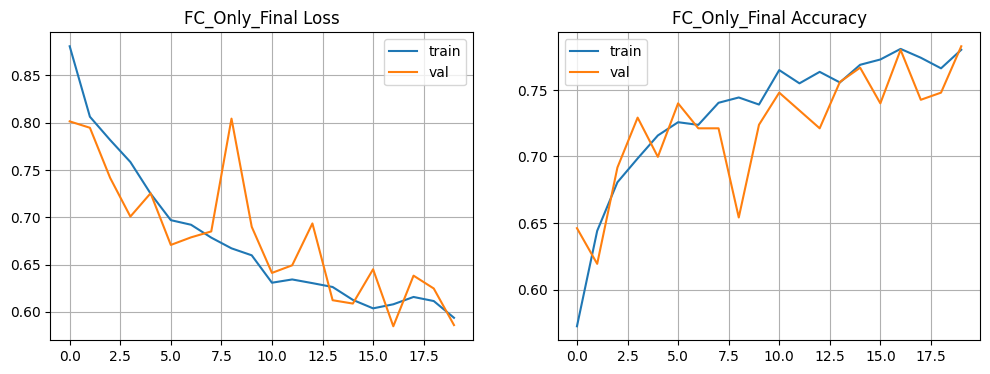

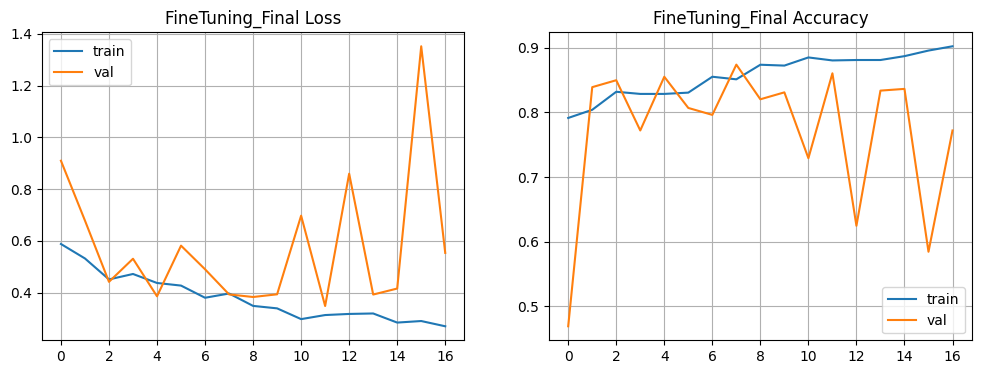


Test Results
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step

 FC Only
                       precision    recall  f1-score   support

Potato___Early_blight       0.75      0.92      0.83       175
 Potato___Late_blight       0.87      0.78      0.82       175
     Potato___healthy       0.00      0.00      0.00        23

             accuracy                           0.80       373
            macro avg       0.54      0.57      0.55       373
         weighted avg       0.76      0.80      0.77       373



/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step

 Fine-tuning
                       precision    recall  f1-score   support

Potato___Early_blight       0.92      0.91      0.92       175
 Potato___Late_blight       0.91      0.90      0.91       175
     Potato___healthy       0.56      0.61      0.58        23

             accuracy                           0.89       373
            macro avg       0.80      0.81      0.80       373
         weighted avg       0.89      0.89      0.89       373



In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import gc
import numpy as np

# Настройки 
DATA_DIR = '/home/verokul/TPU_LABS/Machine_learning_Axyonov/Lab_06/potato_ds'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 3

#  ПРОСТЫЕ аугментации 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    f'{DATA_DIR}/train', target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    f'{DATA_DIR}/val', target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical'
)

test_gen = val_datagen.flow_from_directory(
    f'{DATA_DIR}/test', target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# БЕЗ class weights!

# Функция обучения 
def train_model(model, name, epochs=20):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[
            ModelCheckpoint(f'{name}.keras', monitor='val_accuracy', 
                          save_best_only=True, verbose=1),
            EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
        ],
        verbose=1
    )
    return history

# ВАРИАНТ 1. FC только
print("\nFC Only")
base1 = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base1.trainable = False

x = GlobalAveragePooling2D()(base1.output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(NUM_CLASSES, activation='softmax')(x)

model_fc = Model(base1.input, out)
model_fc.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history_fc = train_model(model_fc, 'model_fc_final_01', epochs=20)

del model_fc, base1
tf.keras.backend.clear_session()
gc.collect()

# ВАРИАНТ 2. Fine-tuning
print("\nFine-tuning")
base2 = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

for layer in base2.layers[:-20]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base2.output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(NUM_CLASSES, activation='softmax')(x)

model_ft = Model(base2.input, out)
model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = train_model(model_ft, 'model_ft_final_01', epochs=25)

#  Графики
def plot(h, name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(h.history['loss'], label='train')
    ax[0].plot(h.history['val_loss'], label='val')
    ax[0].set_title(f'{name} Loss')
    ax[0].legend()
    ax[0].grid()
    
    ax[1].plot(h.history['accuracy'], label='train')
    ax[1].plot(h.history['val_accuracy'], label='val')
    ax[1].set_title(f'{name} Accuracy')
    ax[1].legend()
    ax[1].grid()
    
    plt.savefig(f'{name}_plot.png', dpi=100)
    plt.show()

plot(history_fc, 'FC_Only_Final')
plot(history_ft, 'FineTuning_Final')

# Тест
from sklearn.metrics import classification_report

print("\nTest Results")

m1 = tf.keras.models.load_model('model_fc_final_01.keras')
y_pred_fc = np.argmax(m1.predict(test_gen), axis=1)
y_true = test_gen.classes
print("\n FC Only")
print(classification_report(y_true, y_pred_fc, 
                          target_names=list(test_gen.class_indices.keys())))

m2 = tf.keras.models.load_model('model_ft_final_01.keras')
test_gen.reset()
y_pred_ft = np.argmax(m2.predict(test_gen), axis=1)
print("\n Fine-tuning")
print(classification_report(y_true, y_pred_ft,
                          target_names=list(test_gen.class_indices.keys())))

/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


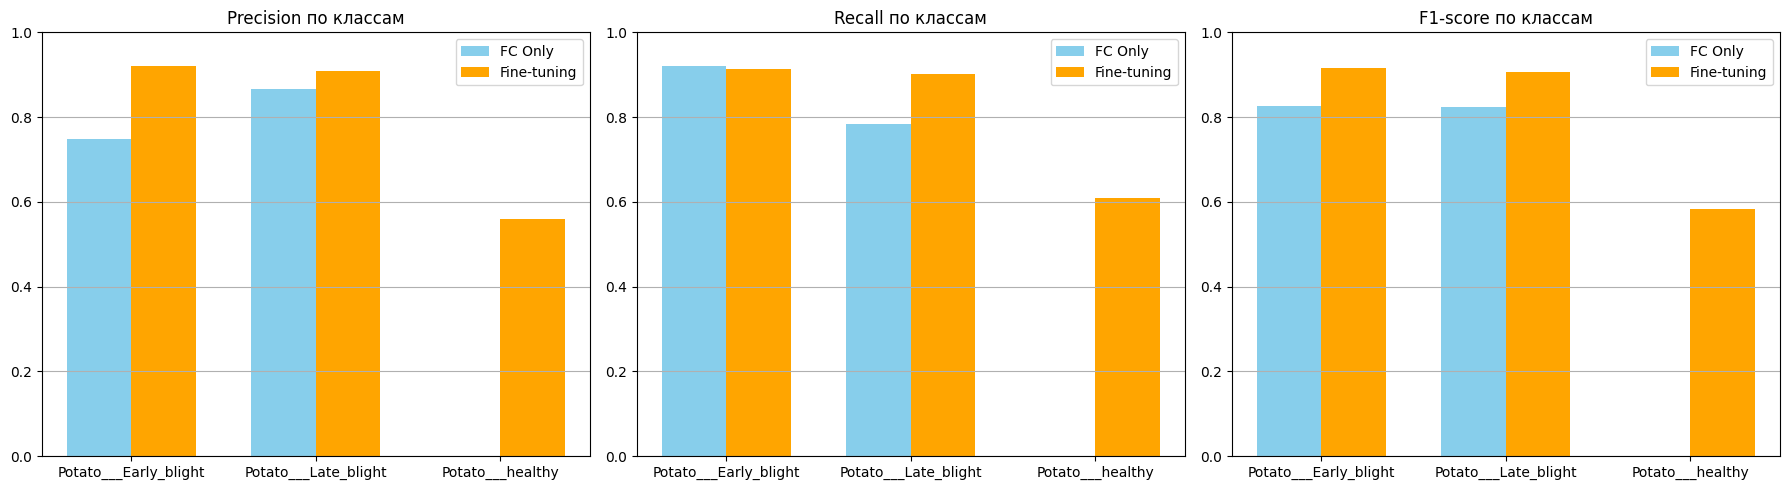

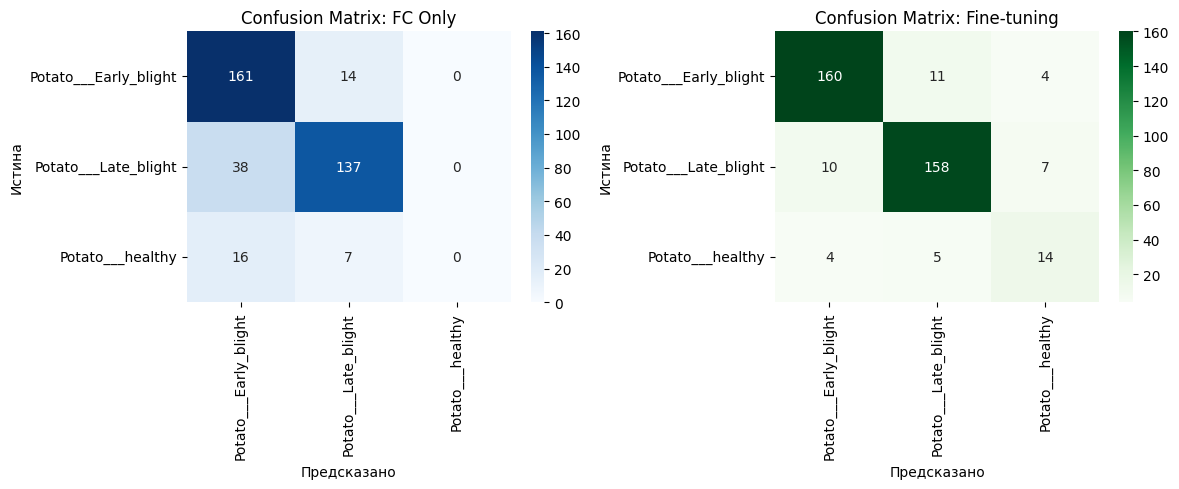

In [4]:
# ГРАФИКИ 
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns


# Classification Report  Bar plots (для FC и Fine-tuning)
class_names = list(test_gen.class_indices.keys())

# Для FC Only
prec_fc, rec_fc, f1_fc, _ = precision_recall_fscore_support(y_true, y_pred_fc, average=None)
# Для Fine-tuning
prec_ft, rec_ft, f1_ft, _ = precision_recall_fscore_support(y_true, y_pred_ft, average=None)

x = np.arange(len(class_names))
width = 0.35

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision
axes[0].bar(x - width/2, prec_fc, width, label='FC Only', color='skyblue')
axes[0].bar(x + width/2, prec_ft, width, label='Fine-tuning', color='orange')
axes[0].set_title('Precision по классам')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names)
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].grid(axis='y')

# Recall
axes[1].bar(x - width/2, rec_fc, width, label='FC Only', color='skyblue')
axes[1].bar(x + width/2, rec_ft, width, label='Fine-tuning', color='orange')
axes[1].set_title('Recall по классам')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names)
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(axis='y')

# F1-score
axes[2].bar(x - width/2, f1_fc, width, label='FC Only', color='skyblue')
axes[2].bar(x + width/2, f1_ft, width, label='Fine-tuning', color='orange')
axes[2].set_title('F1-score по классам')
axes[2].set_xticks(x)
axes[2].set_xticklabels(class_names)
axes[2].set_ylim(0, 1)
axes[2].legend()
axes[2].grid(axis='y')

plt.tight_layout()
plt.savefig('classification_metrics_comparison.png', dpi=150)
plt.show()




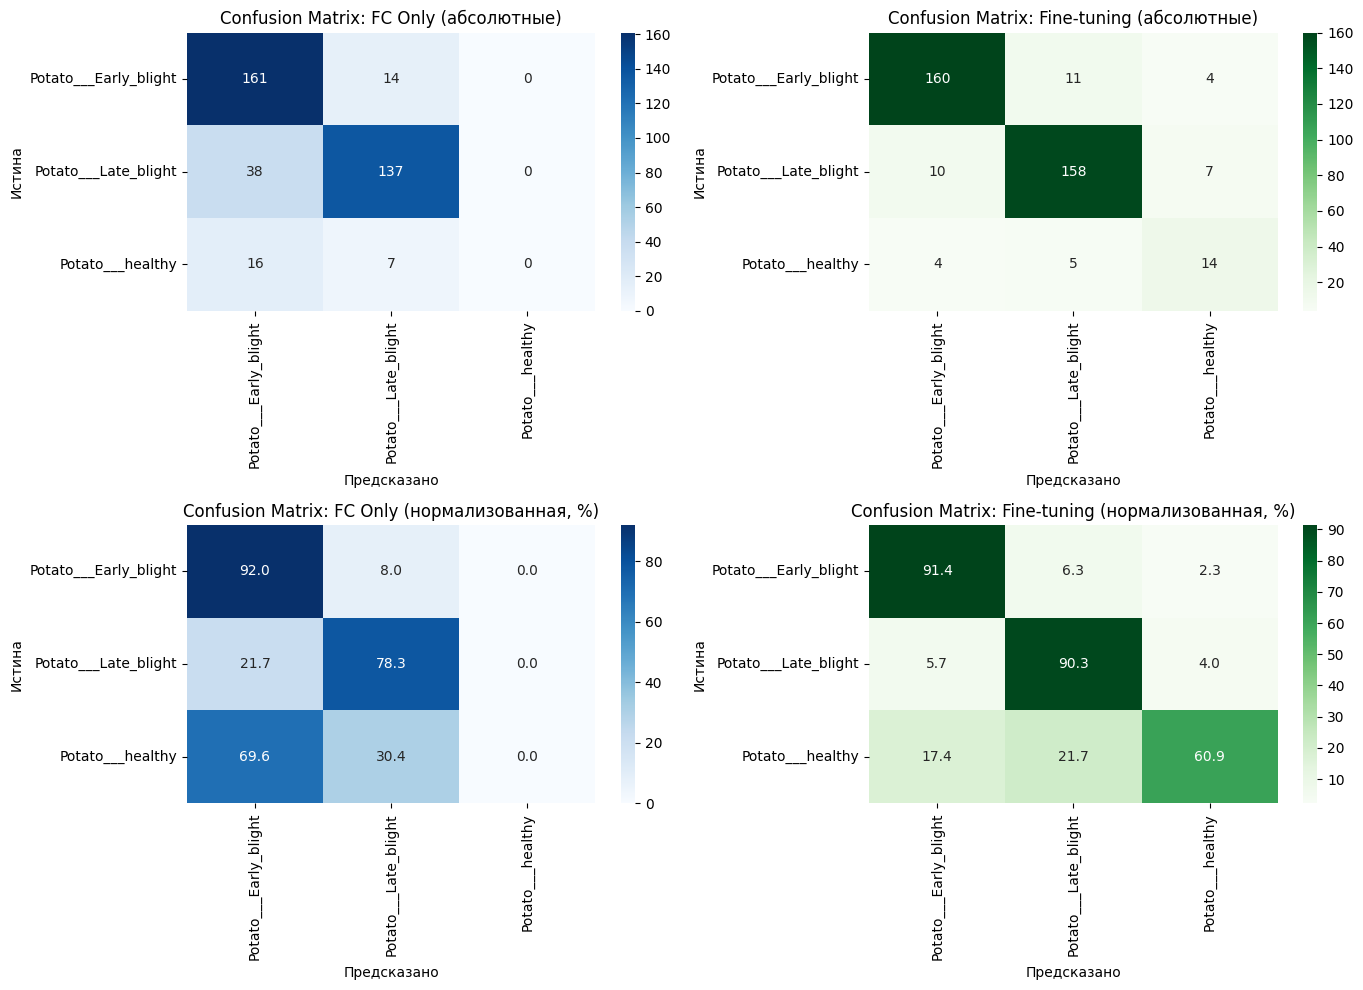

In [5]:
# Confusion Matrices — абсолютные и нормализованные (%)
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cm_fc = confusion_matrix(y_true, y_pred_fc)
cm_ft = confusion_matrix(y_true, y_pred_ft)

# Нормализованные матрицы (по строкам — recall-ориентированные)
cm_fc_norm = cm_fc.astype('float') / cm_fc.sum(axis=1)[:, np.newaxis] * 100  # %
cm_ft_norm = cm_ft.astype('float') / cm_ft.sum(axis=1)[:, np.newaxis] * 100  # %

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Абсолютные значения
sns.heatmap(cm_fc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix: FC Only (абсолютные)')
axes[0, 0].set_xlabel('Предсказано')
axes[0, 0].set_ylabel('Истина')

sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix: Fine-tuning (абсолютные)')
axes[0, 1].set_xlabel('Предсказано')
axes[0, 1].set_ylabel('Истина')

# Нормализованные значения (%)
sns.heatmap(cm_fc_norm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix: FC Only (нормализованная, %)')
axes[1, 0].set_xlabel('Предсказано')
axes[1, 0].set_ylabel('Истина')

sns.heatmap(cm_ft_norm, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix: Fine-tuning (нормализованная, %)')
axes[1, 1].set_xlabel('Предсказано')
axes[1, 1].set_ylabel('Истина')

plt.tight_layout()
plt.savefig('confusion_matrices_absolute_and_normalized.png', dpi=150)
plt.show()